In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vebtf import VEBTF


import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
import timeit

class wavelet_denoise:
    def __init__(self, wavelet='haar', mode='hard', wavelet_levels=None, method='VisuShrink',num_shifts=1,sigma=None):
        self.wavelet = wavelet
        self.mode = mode
        self.wavelet_levels = wavelet_levels
        self.method = method
        self.num_shifts = num_shifts
        self.sigma = sigma
        self.model_name = f"{wavelet}_{method}"

    def fit(self, y):
        """
        Apply translation-invariant wavelet denoising to an y.
        
        Parameters:
        - y: The input y to be denoised.
        - sigma, wavelet, mode, wavelet_levels, convert2ycbcr, method: Parameters for the denoise_wavelet function.
        - num_shifts: Number of shifts for cycle spinning.
        
        Returns:
        - Denoised y with translation-invariant wavelet denoising.
        """
        start_time = timeit.default_timer()
        # mirror the y
        n = len(y)
        y = np.concatenate([y, y[::-1]])
        denoised_y = np.zeros_like(y)
        self.num_shifts = min(self.num_shifts, y.shape[0] - 1)
        shifts = np.linspace(0, y.shape[0] - 1, num=self.num_shifts, dtype=int)
        if self.sigma is None:
            self.sigma = estimate_sigma(y)
        for shift in shifts:
            # Shift the y
            shifted_y = np.roll(y, shift, axis=0)

            # Denoise the shifted y
            denoised_shifted_y = denoise_wavelet(shifted_y, sigma=self.sigma, wavelet=self.wavelet,
                                                    mode=self.mode, wavelet_levels=self.wavelet_levels,method=self.method)

            # Shift back and accumulate the result
            denoised_y += np.roll(denoised_shifted_y, -shift, axis=0)

        # Average the accumulated denoised ys
        denoised_y /= self.num_shifts
        self.mu = denoised_y[0:n]
        self.run_time = timeit.default_timer() - start_time
        #return denoised_y[0:n]


class genlasso_tf:
    def __init__(self,ord=0):
        self.ord = ord
        self.model_name = f"genlasso_tf{ord}"

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        start_time = timeit.default_timer()
        numpy2ri.activate()
        genlasso = importr('genlasso')
        y_r = ro.FloatVector(y)
        fit_tf_r = genlasso.trendfilter(y_r, ord=self.ord)
        fit_tf_cv_r = genlasso.cv_trendfilter(fit_tf_r, k=5, verbose=False)
        fit_tf_coef_r = genlasso.coef_genlasso(fit_tf_r, fit_tf_cv_r.rx2('lambda.1se')) 
        fit_tf = np.array(fit_tf_coef_r.rx2('beta'))
        self.mu=fit_tf.squeeze()
        self.run_time = timeit.default_timer() - start_time
        #return fit_tf.squeeze()


class susie_tf:
    def __init__(self,L=10):
        self.L = L
        self.model_name = f"susie_tf{L}"

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        start_time = timeit.default_timer()
        numpy2ri.activate()
        susieR = importr('susieR')
        y_r = ro.FloatVector(y)
        fit_tf_r = susieR.susie_trendfilter(y_r,L=self.L)
        fit_tf = np.array(susieR.predict_susie(fit_tf_r))
        self.mu = fit_tf.squeeze()
        self.run_time = timeit.default_timer() - start_time
        #return fit_tf.squeeze()




data = """
    0.0 -1.3 -2.7 0.0 -2.7 -2.7 -2.7 -1.3 -2.7 -2.7 -1.3 -2.7 -2.7 -2.7 -5.4 -2.7 -5.4 0.0
    -2.7 -2.7 0.0 -13.3 -5.4 -5.4 -9.3 -16.0 -22.8 -2.7 -22.8 -32.1 -53.5 -54.9 -40.2 -21.5 -21.5 -50.8
    -42.9 -26.8 -21.5 -50.8 -61.7 -5.4 -80.4 -59.0 -71.0 -91.1 -77.7 -37.5 -85.6 -123.1 -101.9 -99.1 -104.4 -112.5
    -50.8 -123.1 -85.6 -72.3 -127.2 -123.1 -117.9 -134.0 -101.9 -108.4 -123.1 -123.1 -128.5 -112.5 -95.1 -81.8 -53.5 -64.4
    -57.6 -72.3 -44.3 -26.8 -5.4 -107.1 -21.5 -65.6 -16.0 -45.6 -24.2 9.5 4.0 12.0 -21.5 37.5 46.9 -17.4
    36.2 75.0 8.1 54.9 48.2 46.9 16.0 45.6 1.3 75.0 -16.0 -54.9 69.6 34.8 32.1 -37.5 22.8 46.9
    10.7 5.4 -1.3 -21.5 -13.3 30.8 -10.7 29.4 0.0 -10.7 14.7 -1.3 0.0 10.7 10.7 -26.8 -14.7 -13.3
    0.0 10.7 -14.7 -2.7 10.7 -2.7 10.7
"""

# Convert the string of numbers into a list of floats
numbers = [float(x) for x in data.split()]

# Convert the list into a NumPy array
y = np.array(numbers)

print(y)

[   0.    -1.3   -2.7    0.    -2.7   -2.7   -2.7   -1.3   -2.7   -2.7
   -1.3   -2.7   -2.7   -2.7   -5.4   -2.7   -5.4    0.    -2.7   -2.7
    0.   -13.3   -5.4   -5.4   -9.3  -16.   -22.8   -2.7  -22.8  -32.1
  -53.5  -54.9  -40.2  -21.5  -21.5  -50.8  -42.9  -26.8  -21.5  -50.8
  -61.7   -5.4  -80.4  -59.   -71.   -91.1  -77.7  -37.5  -85.6 -123.1
 -101.9  -99.1 -104.4 -112.5  -50.8 -123.1  -85.6  -72.3 -127.2 -123.1
 -117.9 -134.  -101.9 -108.4 -123.1 -123.1 -128.5 -112.5  -95.1  -81.8
  -53.5  -64.4  -57.6  -72.3  -44.3  -26.8   -5.4 -107.1  -21.5  -65.6
  -16.   -45.6  -24.2    9.5    4.    12.   -21.5   37.5   46.9  -17.4
   36.2   75.     8.1   54.9   48.2   46.9   16.    45.6    1.3   75.
  -16.   -54.9   69.6   34.8   32.1  -37.5   22.8   46.9   10.7    5.4
   -1.3  -21.5  -13.3   30.8  -10.7   29.4    0.   -10.7   14.7   -1.3
    0.    10.7   10.7  -26.8  -14.7  -13.3    0.    10.7  -14.7   -2.7
   10.7   -2.7   10.7]


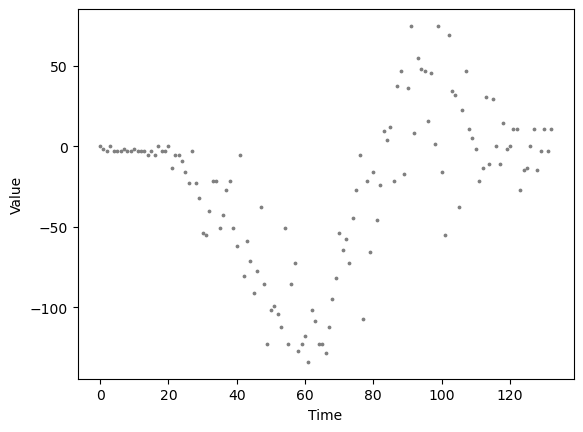

In [2]:
plt.scatter(range(len(y)), y, s=3,c='grey')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [3]:
n = len(y)
model = VEBTF(printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/3,maxiter=1000,num_shift_wavelet=100,method_wavelet='VisuShrink')
model.fit(y,mu_init='lasso')

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Iteration 0: ELBO = -873.5682684021431


In [4]:
model.sigma2

435.9725230399874

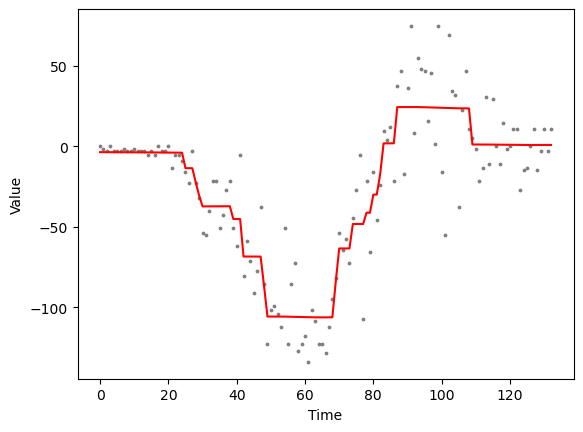

In [5]:
plt.scatter(range(len(y)), y, s=3,c='grey')
plt.plot(range(len(y)), model.mu, c='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


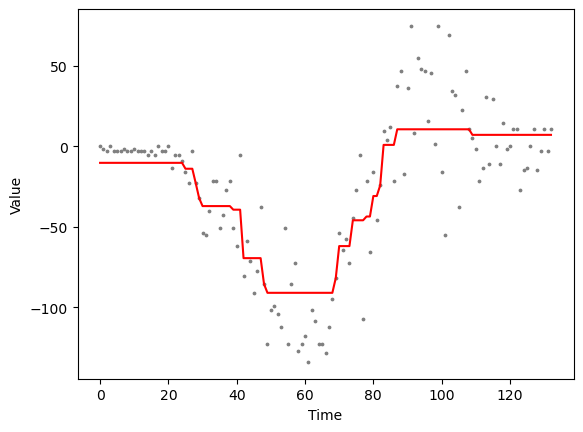

In [6]:
gtf = genlasso_tf()
gtf.fit(y)
plt.scatter(range(len(y)), y, s=3,c='grey')
plt.plot(range(len(y)), gtf.mu, c='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

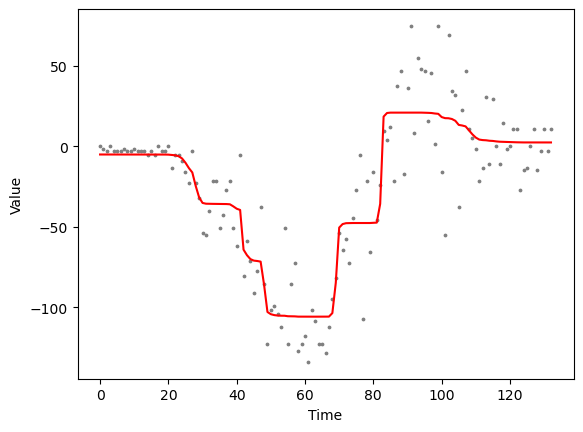

In [7]:
stf = susie_tf(L=20)
stf.fit(y)
plt.scatter(range(len(y)), y, s=3,c='grey')
plt.plot(range(len(y)), stf.mu, c='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

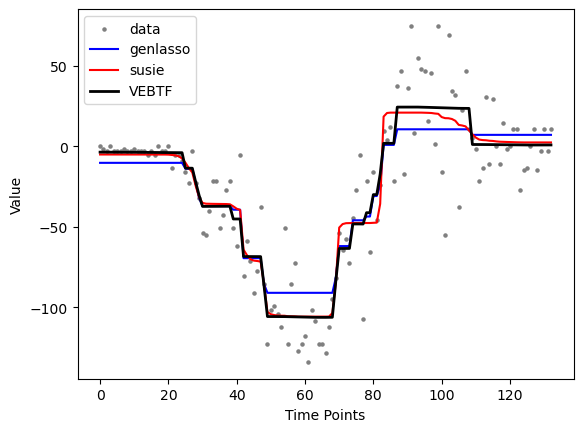

In [8]:
plt.scatter(range(len(y)), y, s=5,c='grey')
plt.plot(range(len(y)), gtf.mu, c='blue')
plt.plot(range(len(y)), stf.mu, c='red')
plt.plot(range(len(y)), model.mu, c='black',linewidth=2)
plt.legend(['data','genlasso','susie','VEBTF'])
plt.xlabel('Time Points')
plt.ylabel('Value')
plt.show()

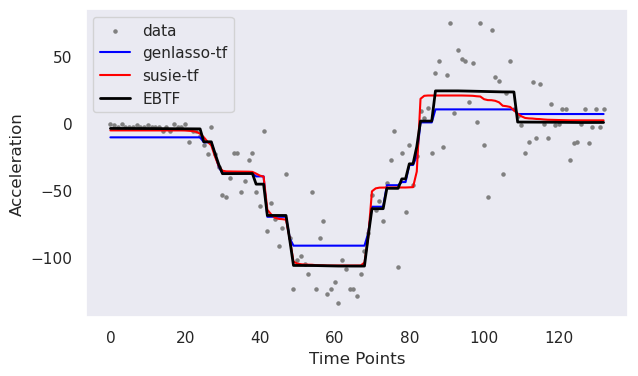

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot using Seaborn
sns.set(style="dark")

# Create the plot
plt.figure(figsize=(7, 4))  # You can adjust the size of the plot
plt.scatter(range(len(y)), y, s=5, c='grey', label='data')
plt.plot(range(len(y)), gtf.mu, c='blue', label='genlasso-tf')
plt.plot(range(len(y)), stf.mu, c='red', label='susie-tf')
plt.plot(range(len(y)), model.mu, c='black', linewidth=2, label='EBTF')

# Add legend, labels, and show the plot
plt.legend()
plt.xlabel('Time Points')
plt.ylabel('Acceleration')
plt.savefig('accel.pdf',bbox_inches='tight')
plt.show()
